In [68]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PersonReID import *
from DeepPersonReID import *
from tqdm import tqdm

In [2]:
Pcam_path = './results_WT_C1s/results.txt'
Scam_path = './results_WT_C4s/results.txt'

In [3]:
with open(Pcam_path) as f:
    pc_lines = [line.rstrip() for line in f]

with open(Scam_path) as f:
    sc_lines = [line.rstrip() for line in f]

In [4]:
pc_frame_dict = {}
for line in pc_lines:
    sline = [x.strip() for x in line.split(',')]
    if int(sline[1]) not in pc_frame_dict.keys():
        pc_frame_dict[int(sline[1])] = []
    # Key = PersonID, Value = [FrameID, X1, Y1, W, H] (Boxes dimension is based on 1088x608)
    pc_frame_dict[int(sline[1])].append([int(sline[0]), int(float(sline[2])), int(float(sline[3])), int(float(sline[4])), int(float(sline[5]))])
len(pc_frame_dict)

602

In [5]:
sc_frame_dict = {}
for line in sc_lines:
    sline = [x.strip() for x in line.split(',')]
    if int(sline[0]) not in sc_frame_dict.keys():
        sc_frame_dict[int(sline[0])] = []
    # Key = FrameID, Value = [PersonID, X1, Y1, W, H] (Boxes dimension is based on 1088x608)
    sc_frame_dict[int(sline[0])].append([int(sline[1]), int(float(sline[2])), int(float(sline[3])), int(float(sline[4])), int(float(sline[5]))])
len(sc_frame_dict)

395

In [6]:
pc_frame_dict[3]

[[2, 878, 71, 33, 92],
 [3, 877, 74, 34, 94],
 [4, 877, 74, 34, 94],
 [5, 871, 79, 35, 98],
 [6, 876, 79, 32, 89],
 [7, 877, 75, 31, 88],
 [8, 877, 76, 34, 95],
 [9, 882, 75, 34, 95],
 [10, 885, 77, 35, 99],
 [11, 880, 78, 35, 100],
 [12, 879, 76, 34, 97],
 [14, 879, 80, 31, 89],
 [15, 880, 78, 31, 89],
 [16, 875, 74, 29, 85],
 [17, 873, 72, 31, 89],
 [18, 877, 73, 30, 89],
 [19, 879, 74, 30, 89],
 [20, 880, 74, 30, 88],
 [21, 876, 74, 29, 87],
 [22, 868, 78, 30, 90],
 [23, 859, 77, 30, 90],
 [24, 847, 75, 29, 85],
 [25, 837, 72, 28, 82],
 [26, 828, 70, 27, 79],
 [27, 825, 78, 28, 83],
 [28, 820, 77, 28, 84],
 [29, 823, 77, 26, 79],
 [30, 823, 73, 26, 78],
 [31, 823, 68, 27, 79],
 [32, 818, 64, 27, 82],
 [36, 802, 64, 26, 78],
 [37, 791, 65, 26, 77],
 [38, 781, 65, 26, 76],
 [39, 772, 64, 25, 76],
 [42, 756, 63, 25, 76],
 [43, 744, 61, 24, 73]]

In [7]:
pc_frame_dict[102]

[[16, 942, 72, 31, 84],
 [17, 941, 69, 32, 88],
 [18, 936, 72, 32, 87],
 [22, 921, 82, 33, 90],
 [24, 917, 83, 35, 96],
 [25, 917, 80, 34, 93]]

In [8]:
pc_largest_dict = {}
for id in pc_frame_dict.keys():
    if id not in pc_largest_dict.keys():
        pc_largest_dict[id] = []
    tracklets = pc_frame_dict[id]
    largest = tracklets[0] # Assign first as seed
    for t in tracklets:
        curr_largest_area = largest[3] * largest[4]
        t_area = t[3] * t[4]
        if curr_largest_area < t_area:
            largest = t
    pc_largest_dict[id] = largest     

In [9]:
pc_largest_dict.keys()

dict_keys([2, 3, 4, 6, 10, 12, 13, 15, 16, 18, 19, 20, 26, 28, 29, 35, 38, 40, 41, 46, 49, 54, 57, 59, 61, 62, 66, 67, 75, 77, 80, 87, 94, 95, 102, 104, 109, 112, 114, 116, 119, 132, 134, 136, 139, 142, 146, 149, 154, 160, 161, 163, 164, 166, 173, 175, 180, 183, 185, 192, 196, 204, 205, 221, 223, 229, 234, 235, 236, 239, 241, 243, 244, 249, 250, 253, 254, 255, 256, 258, 259, 261, 262, 263, 264, 268, 272, 273, 276, 277, 283, 284, 286, 293, 294, 295, 296, 297, 299, 303, 304, 305, 308, 310, 315, 316, 317, 320, 322, 325, 326, 329, 331, 336, 338, 343, 344, 346, 348, 353, 354, 357, 362, 365, 366, 368, 369, 371, 372, 373, 374, 375, 377, 379, 380, 385, 388, 393, 394, 397, 401, 402, 403, 404, 406, 407, 413, 415, 417, 418, 421, 423, 424, 425, 427, 434, 435, 436, 441, 443, 445, 446, 450, 453, 454, 455, 456, 457, 463, 465, 469, 475, 480, 482, 485, 486, 490, 494, 496, 509, 510, 511, 518, 520, 522, 523, 524, 525, 527, 528, 530, 534, 537, 543, 545, 546, 548, 550, 553, 554, 557, 558, 565, 567, 568, 56

In [10]:
sc_largest_dict = {}
for id in sc_frame_dict.keys():
    if id not in sc_largest_dict.keys():
        sc_largest_dict[id] = []
    tracklets = sc_frame_dict[id]
    largest = tracklets[0] # Assign first as seed
    for t in tracklets:
        curr_largest_area = largest[3] * largest[4]
        t_area = t[3] * t[4]
        if curr_largest_area < t_area:
            largest = t
    sc_largest_dict[id] = largest 

In [11]:
sc_largest_dict.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [12]:
raw_pc_path = os.path.join('.','results_WT_C1s','raw_frame')
raw_sc_path = os.path.join('.','results_WT_C4s','raw_frame')
out_width = 1088
out_height = 608

In [13]:
%%time
raw_pc_frames = []
for frame in os.listdir(raw_pc_path):
    pcimg = cv2.imread(os.path.join(raw_pc_path, frame))
    pcimg = cv2.cvtColor(pcimg, cv2.COLOR_BGR2RGB)
    pcimg = cv2.resize(pcimg, (out_width, out_height))
    raw_pc_frames.append(pcimg)

raw_sc_frames = []
for frame in os.listdir(raw_sc_path):
    scimg = cv2.imread(os.path.join(raw_sc_path, frame))
    scimg = cv2.cvtColor(scimg, cv2.COLOR_BGR2RGB)
    scimg = cv2.resize(scimg, (out_width, out_height))
    raw_sc_frames.append(scimg)

Wall time: 49.5 s


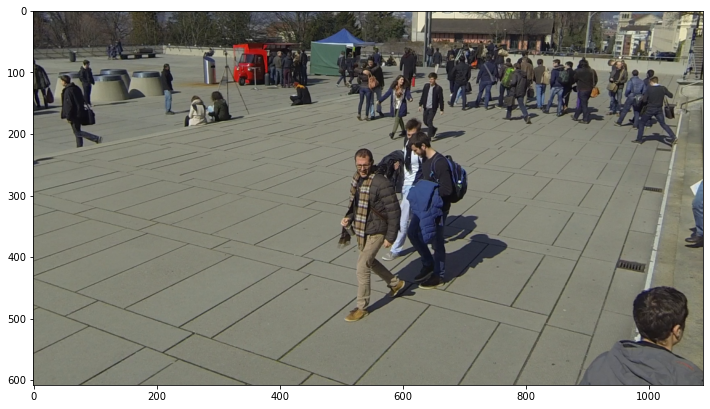

In [14]:
plt.figure(figsize=(12, 8))
plt.imshow(raw_pc_frames[0])

In [15]:
reid = PersonReid(device=torch.device('cuda'))

In [16]:
frame_ranger = 30
score_threshold = 0.9
out_pc_folder = os.path.join('.','results_WT_C1s','rf_largest_bbox')
out_sc_folder = os.path.join('.','results_WT_C4s','rf_largest_bbox')

In [42]:
def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

def slice_det(frame, boxes):
    det_slice = {}
    for bidx in range(len(boxes)):
        x1, y1 = boxes[bidx][0], boxes[bidx][1]
        x2, y2 = boxes[bidx][0] + boxes[bidx][2], boxes[bidx][1] + boxes[bidx][3]
        det_slice[bidx] = frame[y1:y2, x1:x2]
    return det_slice

def draw_bbox(frame, boxes, idx):
    font_scale = 0.8
    thickness = 2
    for bidx in range(len(boxes)):
        x, y = boxes[0], boxes[1]
        w, h = boxes[2], boxes[3]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=thickness)
        text = str(idx)
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
        text_offset_x = x
        text_offset_y = y - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
        overlay = frame.copy()
        cv2.rectangle(overlay, box_coords[0], box_coords[1], color=(0, 0, 255), thickness=cv2.FILLED)
        frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
        cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
    return frame

In [70]:
%%time
reid_output = {}
# Loop thru all the largest bounding box : pc_largest_dict keys = person id
for idx in tqdm(pc_largest_dict.keys()):
    # The single largest tracklet for person idx
    tracklet = pc_largest_dict[idx]
    # Frame in which the largest tracklet is in is store in first slot [0]
    frameid = tracklet[0]
    # Bounding box for largest tracklet is store in last 4 [1:]
    pc_box = tracklet[1:]
    if pc_box[0] < 0 or pc_box[1] < 0 or pc_box[2] < 0 or pc_box[3] < 0:
        print('Invalid Bounding Box (PC_BOXES)')
        continue
    pc_boxes = []
    pc_boxes.append(pc_box)
    # Get the raw frame indicated above
    raw_frame = raw_pc_frames[frameid-1]
    # Get a dictonary of image slices of all the detection boxes
    pc_slices = slice_det(raw_frame, pc_boxes)
    # Extract features of all the slices
    with torch.no_grad():
        pc_features = reid.extract_features(list(pc_slices.values()))
    # Draw largest bbox on frame
    # raw_pc_frames[frameid-1] = draw_bbox(raw_frame, boxes, idx) #TODO
    # Based on the largest bounding box found, use frame from primary cam as reference and set a -30/+30 frame range
    frame_range = [clamp((frameid-frame_ranger), 0, len(raw_pc_frames)-1), clamp((frameid+frame_ranger), 0, len(raw_pc_frames)-1)]
    # Iterate thru the frame range for all bounding boxs in secondary cam. Skip frame if no bounding box found
    print(f'PersonID[{idx}] -> Frame[{frameid}] -> FrameRange -> {frame_range[0]} to {frame_range[1]}')
    for i in range(frame_range[0], frame_range[1]):
        findex = i
        # print(f'findex: {findex}')
        try:
            # Try to get the raw frame and raw tracklet of the current frameID
            scp_frame = raw_sc_frames[findex]
            # print(f'scp_frame: {scp_frame.shape}')
            scp_tracklets = sc_frame_dict[findex]
            # print(f'scp_tracklets: {len(scp_tracklets)}')
        except:
            # print('No Frame or Tracklets')
            continue
        # Get only the bounding boxes
        boxes = []
        for t in scp_tracklets:
            boxes.append(t[1:])
        # Get a dictionary of image slices of all the detection boxes
        sc_slices = {}
        # print(f'boxes: {len(boxes)}')
        for idx in range(len(boxes)):
            x1, y1 = boxes[idx][0], boxes[idx][1]
            x2, y2 = boxes[idx][0] + boxes[idx][2], boxes[idx][1] + boxes[idx][3]
            if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0: #TODO: Find out why < 0?
                print('Invalid Bounding Box (SC_BOXES)')
                continue
            # print(f'x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}')
            sc_slices[idx] = scp_frame[y1:y2, x1:x2]
        # Extract features of all the slices
        with torch.no_grad():
            sc_features = reid.extract_features(list(sc_slices.values()))
        # print(f'pc_features: {len(pc_features)}')
        # print(f'sc_features: {len(sc_features)}')
        # Perform REID matching
        qScore_idx = reid.reid(pc_features, sc_features, score_threshold)
        # print(f'qScore: {qScore_idx}')
        if findex not in reid_output.keys():
            reid_output[findex] = {}
        if bool(qScore_idx):
            gindex = qScore_idx[0]
            if gindex not in reid_output[findex].keys():
                reid_output[findex][gindex] = []
            reid_output[findex][gindex].append([idx, boxes[gindex][0], boxes[gindex][1], boxes[gindex][2], boxes[gindex][3]])

 261 to 321
 80%|███████▉  | 481/602 [1:03:53<15:32,  7.71s/it]Invalid Bounding Box (PC_BOXES)
PersonID[1191] -> Frame[297] -> FrameRange -> 267 to 327
 83%|████████▎ | 499/602 [1:05:47<09:49,  5.72s/it]PersonID[1235] -> Frame[328] -> FrameRange -> 298 to 358
Invalid Bounding Box (SC_BOXES)
 83%|████████▎ | 502/602 [1:06:02<08:47,  5.27s/it]Invalid Bounding Box (SC_BOXES)
PersonID[1240] -> Frame[338] -> FrameRange -> 308 to 368
Invalid Bounding Box (SC_BOXES)
Invalid Bounding Box (SC_BOXES)
 84%|████████▎ | 503/602 [1:06:06<08:08,  4.93s/it]PersonID[1241] -> Frame[349] -> FrameRange -> 319 to 379
Invalid Bounding Box (SC_BOXES)
Invalid Bounding Box (SC_BOXES)
 84%|████████▎ | 504/602 [1:06:10<07:38,  4.68s/it]PersonID[1244] -> Frame[340] -> FrameRange -> 310 to 370
Invalid Bounding Box (SC_BOXES)
Invalid Bounding Box (SC_BOXES)
 84%|████████▍ | 505/602 [1:06:15<07:22,  4.56s/it]PersonID[1245] -> Frame[334] -> FrameRange -> 304 to 364
Invalid Bounding Box (SC_BOXES)
Invalid Bounding Box

In [79]:
sc_frame_dict[3]

[[1, 472, 74, 43, 147],
 [4, 314, 78, 48, 152],
 [6, 280, 71, 51, 156],
 [7, 968, 176, 124, 337]]

In [ ]:
for idx in tqdm(range(len(reid_output))):
    

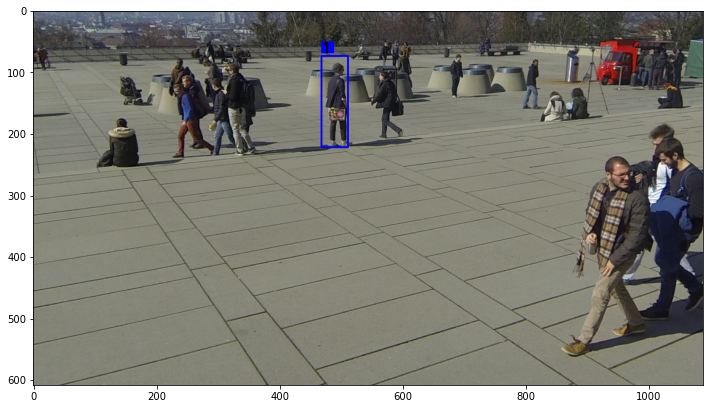

In [20]:
plt.figure(figsize=(12, 8))
plt.imshow(test_f)

In [38]:
for fi in range(len(raw_pc_frames)):
    path = os.path.join(out_pc_folder, f'{fi}.png')
    cv2.imwrite(path, raw_pc_frames[fi])

In [75]:
temp = list(sc_slices.values())
print(temp)

[array([], shape=(74, 0, 3), dtype=uint8), array([], shape=(36, 0, 3), dtype=uint8), array([], shape=(61, 0, 3), dtype=uint8)]
